<a href="https://colab.research.google.com/github/YusolCho/NLPstudy/blob/main/NLP_Dacon_%EC%B5%9C%EC%A2%85%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **패키지, 데이터 로드**

In [2]:
#패키지 임포트 

# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# regex
import re

# stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# tokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TreebankWordTokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Vectorizer
import gensim
import urllib.request #*********
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Padding 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

#DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input

#scoring
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
#파일 불러오기 
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/MyDrive/train.csv'
train = pd.read_csv(filename,delimiter=',',index_col=0)# 첫번째 행을 index행으로

filename2 = '/content/drive/MyDrive/test_x.csv'
test = pd.read_csv(filename2,delimiter=',',index_col=0)# 첫번째 행을 index행으로

Mounted at /content/drive


In [4]:
# additional data cleaning
# 이 함수를 test에도 적용하면 됨

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): 

    review = re.sub("[^a-zA-Z -]","",texts[i]) #대괄호 내 문자들을 제외한 모든 문자 제거
    review = review.lower() #소문자 변환
    review = re.sub(r'\s+', ' ', review) #extra space 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    review = re.sub(r'"+', ' ', review) #spaces 제거   
    review = re.sub('-{2,}', ' ', review) #-이 2번이상 반복되면 제거   

    corpus.append(review) 
  
  return corpus

In [5]:
temp = clean_text(train['text'])
train['clean_text'] = temp

temp = clean_text(test['text'])
test['clean_text'] = temp

test.head() #깨끗함

,text,clean_text
index,,
0,“Not at all. I think she is one of the most ch...,not at all i think she is one of the most char...
1,"""No,"" replied he, with sudden consciousness, ""...",no replied he with sudden consciousness not to...
2,As the lady had stated her intention of scream...,as the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...,and then suddenly in the silence i heard a sou...
4,His conviction remained unchanged. So far as I...,his conviction remained unchanged so far as i ...


In [6]:
# 개별 문장들을 작가마다 하나로 합치는 코드1
corpus_by_author = []
for num in range(5):
    corpus_by_author.append([i for i in train[train['author']==num]['clean_text']])

In [7]:
# 개별 문장들을 작가마다 하나로 합치는 코드2
corpus_all = []
tags=['NN','NNP']

for i in range(5):
    words = " ".join(corpus_by_author[i])
    words = words.split()
    tagged = nltk.pos_tag(words)
    allnoun = [word for word, pos in tagged if pos in tags]
    words = " ".join(allnoun)
    corpus_all.append(words)

In [8]:
train.head()

,text,author,clean_text
index,,,
0,"He was almost choking. There was so much, so m...",3,he was almost choking there was so much so muc...
1,"“Your sister asked for it, I suppose?”",2,your sister asked for it i suppose
2,"She was engaged one day as she walked, in per...",1,she was engaged one day as she walked in perus...
3,"The captain was in the porch, keeping himself ...",4,the captain was in the porch keeping himself c...
4,"“Have mercy, gentlemen!” odin flung up his han...",3,have mercy gentlemen odin flung up his hands d...


In [9]:
train[['clean_text','author']].to_csv('/content/drive/MyDrive/clean_train.csv')
test[['clean_text']].to_csv('/content/drive/MyDrive/clean_test.csv')

In [10]:
detokenized_doc = train['clean_text']

# **임베딩 + 모델링**

## **사전훈련 된 GloVe 를 이용한 임베딩**

- 정수인코딩 후 패딩

In [11]:
# 단어 집합 생성 + 정수인코딩 : using keras Tokenizer

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(detokenized_doc) 
vocab_size = len(tokenizer.word_index) + 1 # 📌 패딩을 고려하여 +1 (0값)
print('단어 집합 : ', vocab_size)

# 정수 인코딩 

X_encoded = tokenizer.texts_to_sequences(detokenized_doc) 
max_len = max(len(l) for l in X_encoded)    # 가장 길이가 긴 문장의 길이 구하기(for padding)
print('최대길이 :', max_len)

단어 집합 :  36922
최대길이 : 473


In [12]:
# 패딩 진행 

X_pad = pad_sequences(X_encoded, maxlen=max_len, padding='post')
print('패딩 결과 :')
print(X_pad)

패딩 결과 :
[[   9   12  237 ...    0    0    0]
 [  49  316  145 ...    0    0    0]
 [  27   12  808 ...    0    0    0]
 ...
 [  49 2585   70 ...    0    0    0]
 [  66   10  429 ...    0    0    0]
 [  11  306   16 ...    0    0    0]]


- 사전훈련 모델 로드 후 모델 크기 확인하기 

In [13]:
# GloVe

from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [14]:
print('벡터의 차원 수 :',len(embedding_dict['odin']))

벡터의 차원 수 : 100


- 임베딩 행렬 만들고 크기 확인

In [15]:
# 임베딩 행렬 틀 짜기 

embedding_matrix = np.zeros((vocab_size, 100))

In [16]:
for word, index in tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = embedding_dict.get(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

In [17]:
print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix))

임베딩 행렬의 크기(shape) : (36922, 100)


## **모델링1**

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

output_dim = 100

model_1 = Sequential()
model_1.add(Input(shape=(max_len,), dtype='int32'))
e = Embedding(vocab_size, output_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)
# trainable = False : 사전 훈련된 임베딩을 그대로 사용 (추가훈련 X)

model_1.add(e)
model_1.add(Dense(64, activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(5, activation='softmax'))


model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# model summary
print(model_1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 473, 100)          3692200   
                                                                 
 dense (Dense)               (None, 473, 64)           6464      
                                                                 
 flatten (Flatten)           (None, 30272)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                968736    
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 4,667,565
Trainable params: 975,365
Non-trainable params: 3,692,200
_________________________________________________________________
None


In [19]:
y_train = train['author']

In [20]:
model_1.fit(X_pad, y_train, epochs = 4, verbose=2, validation_split = 0.2)

Epoch 1/4
1372/1372 - 8s - loss: 1.2957 - acc: 0.4593 - val_loss: 1.1183 - val_acc: 0.5519 - 8s/epoch - 6ms/step
Epoch 2/4
1372/1372 - 4s - loss: 0.9869 - acc: 0.6116 - val_loss: 1.0607 - val_acc: 0.5815 - 4s/epoch - 3ms/step
Epoch 3/4
1372/1372 - 4s - loss: 0.8353 - acc: 0.6768 - val_loss: 1.0836 - val_acc: 0.5836 - 4s/epoch - 3ms/step
Epoch 4/4
1372/1372 - 6s - loss: 0.7356 - acc: 0.7200 - val_loss: 1.1233 - val_acc: 0.5870 - 6s/epoch - 4ms/step


In [22]:
model_1.evaluate(X_pad, y_train)


1715/1715 [==============================] - 5s 3ms/step - loss: 0.7131 - acc: 0.7410


[0.7130637764930725, 0.7409573793411255]

- 모델 정확도 : 0.1316

## **모델링2**

In [28]:
# 파라미터 설정 
vocab_size = 36922
embedding_dim = 100
max_len = 473
padding_type='post'

# 모델 
model_2 = Sequential()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(5, activation='softmax')(output)
model_2 = Model(model_input, model_output)

model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 473)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 473, 100)     3692200     ['input_5[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 472, 512)     102912      ['embedding_4[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 471, 512)     154112      ['embedding_4[0][0]']            
                                                                                            

In [29]:
history = model_2.fit(X_pad, y_train,
          batch_size=64,
          epochs=15,
          validation_split = 0.2)

Epoch 1/15
686/686 [==============================] - 29s 42ms/step - loss: 1.1955 - acc: 0.5192 - val_loss: 0.9702 - val_acc: 0.6253
Epoch 2/15
686/686 [==============================] - 28s 41ms/step - loss: 0.9426 - acc: 0.6323 - val_loss: 0.9021 - val_acc: 0.6555
Epoch 3/15
686/686 [==============================] - 28s 41ms/step - loss: 0.8381 - acc: 0.6756 - val_loss: 0.8271 - val_acc: 0.6883
Epoch 4/15
686/686 [==============================] - 28s 41ms/step - loss: 0.7635 - acc: 0.7084 - val_loss: 0.8042 - val_acc: 0.6948
Epoch 5/15
686/686 [==============================] - 28s 41ms/step - loss: 0.6994 - acc: 0.7327 - val_loss: 0.7837 - val_acc: 0.7074
Epoch 6/15
686/686 [==============================] - 28s 41ms/step - loss: 0.6421 - acc: 0.7568 - val_loss: 0.7942 - val_acc: 0.7044
Epoch 7/15
686/686 [==============================] - 28s 41ms/step - loss: 0.5955 - acc: 0.7761 - val_loss: 0.7948 - val_acc: 0.7085
Epoch 8/15
686/686 [==============================] - 28s 41ms

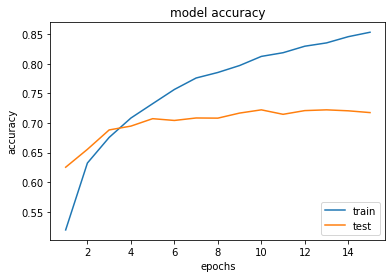

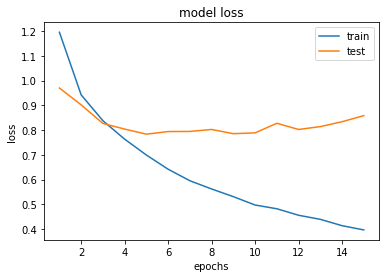

In [30]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()